# Anchor explanations for fashion MNIST

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)  # suppress deprecation messages
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import AnchorImage

### Load and prepare fashion MNIST data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


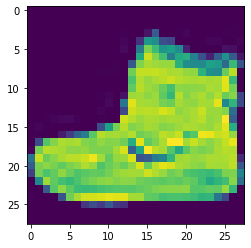

In [3]:
idx = 0
plt.imshow(x_train[idx]);

Scale, reshape and categorize data

In [4]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


### Define CNN model

In [5]:
def model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)
    
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return cnn

In [6]:
cnn = model()
cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0     

### Train model

In [7]:
cnn.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3
60000/60000 [==============================] - 25s 415us/sample - loss: 0.5894 - acc: 0.7827
Epoch 2/3
60000/60000 [==============================] - 28s 461us/sample - loss: 0.4074 - acc: 0.8526
Epoch 3/3
60000/60000 [==============================] - 30s 494us/sample - loss: 0.3672 - acc: 0.8652


In [8]:
# Evaluate the model on test set
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.8866


### Define superpixels

Function to generate rectangular superpixels for a given image. Alternatively, use one of the built in methods. It is important to have meaningful superpixels in order to generate a useful explanation. Please check scikit-image's [segmentation methods](http://scikit-image.org/docs/dev/api/skimage.segmentation.html) (*felzenszwalb*, *slic* and *quickshift* built in the explainer) for more information on the built in methods.

In [9]:
def superpixel(image, size=(4, 7)):
    segments = np.zeros([image.shape[0], image.shape[1]])
    row_idx, col_idx = np.where(segments == 0)
    for i, j in zip(row_idx, col_idx):
        segments[i, j] = int((image.shape[1]/size[1]) * (i//size[0]) + j//size[1])
    return segments

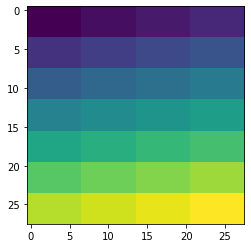

In [10]:
segments = superpixel(x_train[idx])
plt.imshow(segments);

### Define prediction function

In [11]:
predict_fn = lambda x: cnn.predict(x)

### Initialize anchor image explainer

In [12]:
image_shape = x_train[idx].shape
explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=superpixel)

### Explain a prediction

The explanation returns a mask with the superpixels that constitute the anchor.

Image to be explained:

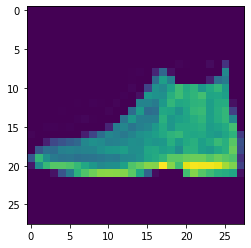

In [13]:
i = 0
image = x_test[i]
plt.imshow(image[:,:,0]);

Model prediction:

In [14]:
cnn.predict(image.reshape(1, 28, 28, 1)).argmax()

9

The predicted category correctly corresponds to the class `ankle boot`:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Generate explanation:

In [15]:
explanation = explainer.explain(image, threshold=.95, p_sample=.8)

Show anchor:

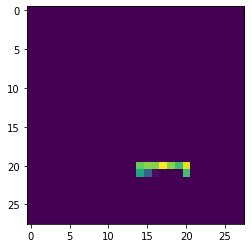

In [16]:
plt.imshow(explanation.anchor[:,:,0]);

From the example, it looks like the arch of the boot alone is sufficient to predict an ankle boot.